In [3]:
import numpy as np
import pandas as pd

In [4]:
# Data loading

dataset = pd.read_csv('data/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
dataset.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,14820,14822,14824,14820,14828,14819,14822,14822,14820,14822,14820,14819,14820,14821,14815,14830,14824,14825,14820,14820,14824,14822,14817,14825,14820,14814,14822,14823,14824,14820,...,14815,14816,14817,14825,14817,14818,14823,14821,14824,14821,14824,14815,14817,14823,14820,14816,14818,14824,14815,14820,14818,14818,14818,14816,14824,14822,14823,14816,14818,14823,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,14823,14823,14822,14824,14827,14824,14822,14823,14823,14824,14824,14820,14824,14823,14822,14818,14828,14819,14824,14823,14820,14821,14822,14817,14824,14821,14823,14822,14819,14825,...,14818,14820,14824,14816,14819,14828,14820,14821,14824,14817,14818,14819,14820,14820,14822,14826,14824,14815,14819,14820,14820,14821,14819,14825,14822,14819,14824,14827,14817,14824,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,14823,14823,14823,14824,14819,14820,14823,14821,14820,14822,14818,14819,14820,14824,14822,14822,14820,14820,14824,14822,14820,14822,14823,14823,14822,14815,14820,14824,14827,14827,...,14819,14818,14824,14821,14820,14819,14824,14825,14818,14820,14820,14816,14815,14821,14820,14827,14819,14819,14824,14821,14819,14822,14822,14820,14820,14822,14822,14826,14823,14822,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,14820,14824,14826,14821,14818,14826,14820,14824,14824,14822,14823,14820,14819,14820,14820,14823,14820,14824,14823,14820,14823,14825,14827,14822,14818,14828,14824,14828,14820,14822,...,14822,14820,14817,14827,14819,14826,14824,14823,14823,14822,14824,14823,14823,14823,14820,14821,14823,14822,14824,14822,14820,14820,14820,14825,14820,14822,14823,14821,14824,14824,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,14822,14825,14822,14823,14820,14823,14823,14821,14820,14826,14820,14818,14819,14821,14822,14825,14820,14823,14823,14817,14823,14827,14823,14820,14817,14823,14828,14818,14823,14825,...,14820,14816,14819,14824,14819,14819,14820,14820,14823,14819,14820,14822,14823,14822,14817,14821,14820,14821,14817,14824,14820,14817,14820,14817,14823,14823,14820,14823,14820,14819,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [5]:
dataset.shape

(23479, 500)

Text(0, 0.5, 'bit ADC')

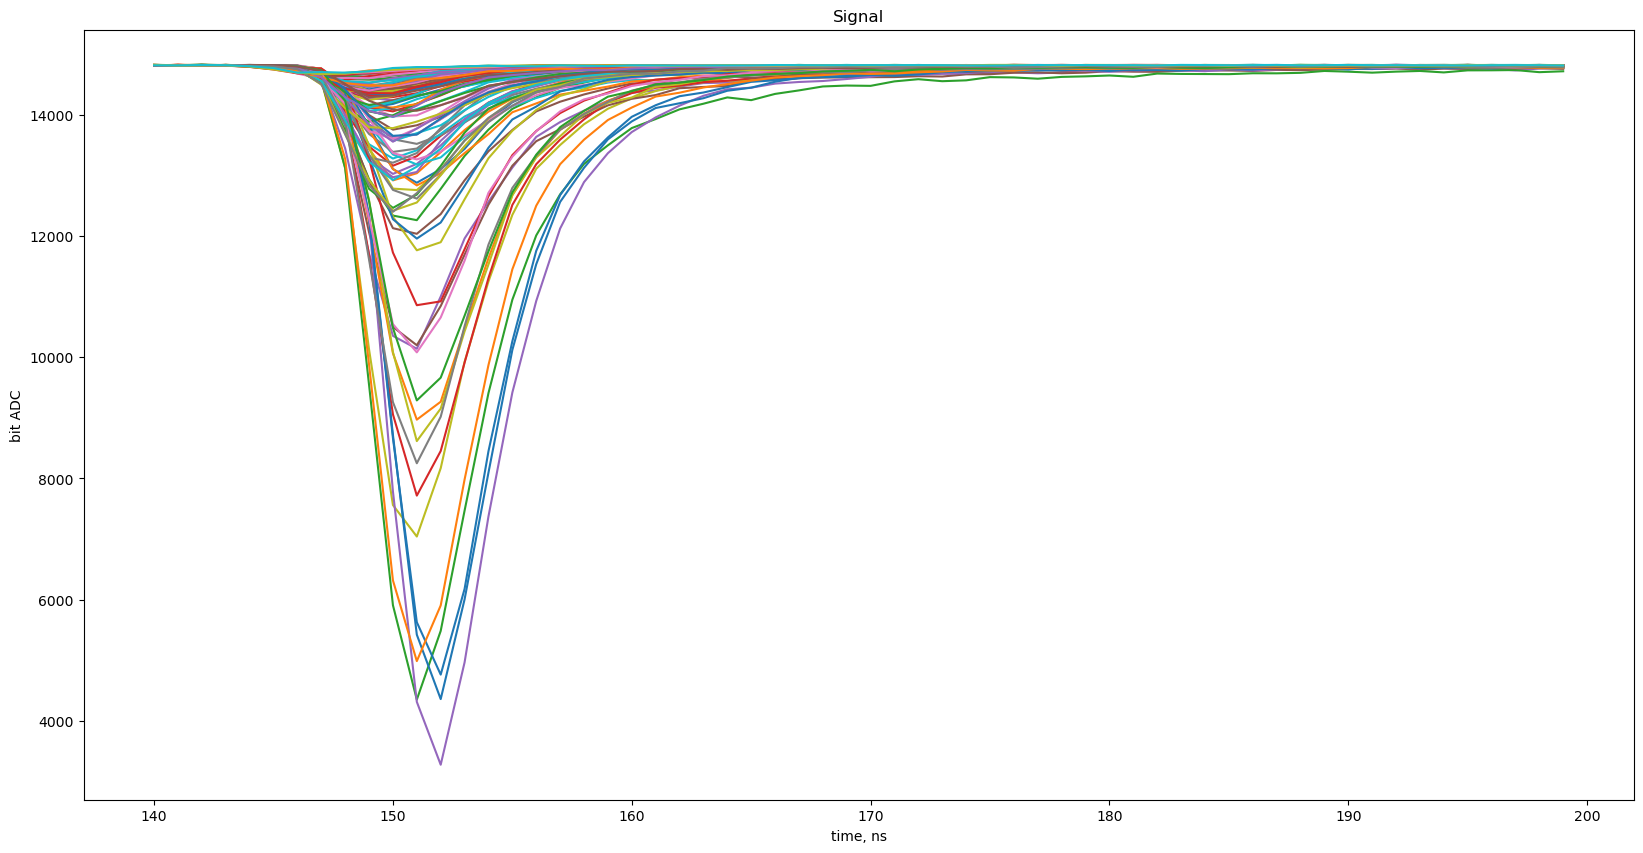

In [6]:
N=range(0,100)
ax = dataset.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Text(0, 0.5, 'bit ADC')

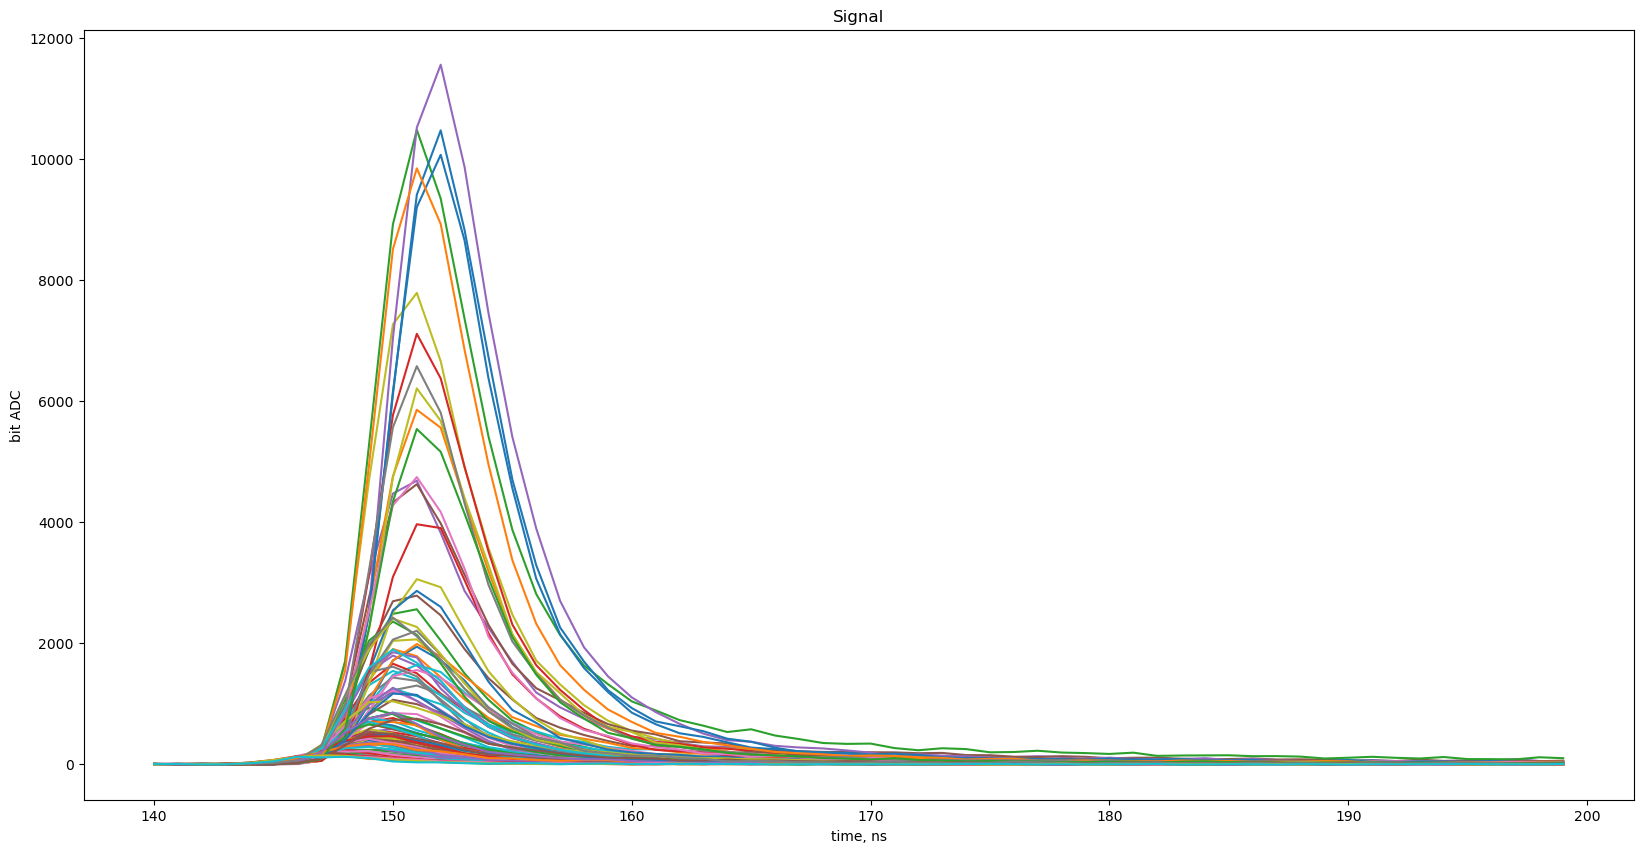

In [7]:
ax = (2**14-dataset.T[N]-1560)[140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")


# baseline

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
# Нормализация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [10]:
# Извлечение амплитуды и площади под сигналом
features = pd.DataFrame()
features['amplitude'] = dataset.max(axis=1)
features['area'] = dataset.sum(axis=1)

In [11]:
# Добавление времени до пика (индекс максимального значения)
features['time_to_peak'] = dataset.idxmax(axis=1)

In [12]:
from sklearn.decomposition import PCA

# Снижение размерности
pca = PCA(n_components=0.95)  # Сохранение 95% дисперсии
reduced_data = pca.fit_transform(features)

In [13]:
from sklearn.cluster import KMeans

# Кластеризация на 3 кластера
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Преобразование меток к порядку 0,1,2 (если необходимо)
# Предположим, что кластеры уже пронумерованы правильно

In [14]:
# Сохранение в нужном формате
result = pd.DataFrame({'index': dataset.index, 'cluster': clusters})
result = result.sort_values('cluster')  # По порядку индексов
result.to_csv('data/submission.csv', index=False)

# Optimize

In [15]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

# Загрузка данных
dataset = pd.read_csv('data/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))

2. Выделение и параметризация сигналов

Ключевые параметры из файла:

Амплитуда сигнала: максимальное значение.
Площадь под кривой: интеграл сигнала.
Время высвечивания (τ): аппроксимация экспонентой с отступом 40% от максимума.
PSD (Pulse Shape Discrimination).

In [16]:
def extract_features(signal):
    try:
        # Нулевая линия по первым 50 точкам
        baseline = np.mean(signal[:50])
        noise_std = np.std(signal[:50])
        signal_clean = signal - baseline
        
        # Амплитуда и позиция максимума
        amplitude = np.max(signal_clean)
        max_pos = np.argmax(signal_clean)
        
        # Конец сигнала (3σ от нулевой линии)
        after_peak = signal_clean[max_pos:]
        below_threshold = np.where(after_peak < 3 * noise_std)[0]
        end_pos = below_threshold[0] + max_pos if len(below_threshold) > 0 else len(signal)-1
        
        # Корректировка end_pos
        if end_pos <= max_pos:
            end_pos = max_pos + 1
            if end_pos >= len(signal):
                end_pos = len(signal) - 1
        
        # Площадь под сигналом (от максимума до конца)
        volume = np.trapz(np.clip(signal_clean[max_pos:end_pos+1], 0, None))
        
        # Поиск точки начала для τ (40% от амплитуды)
        # Ищем первое значение после максимума, которое ниже 40% амплитуды
        threshold = 0.4 * amplitude
        below_40 = np.where(signal_clean[max_pos:end_pos+1] < threshold)[0]
        
        if len(below_40) > 0:
            start_tau_idx = below_40[0] + max_pos
        else:
            # Если не нашли - используем фиксированный отступ (10 точек)
            start_tau_idx = min(max_pos + 10, end_pos)
        
        # Аппроксимация экспонентой для τ
        if start_tau_idx < end_pos:
            t = np.arange(start_tau_idx, end_pos+1)
            y = signal_clean[start_tau_idx:end_pos+1]
            # Фильтрация отрицательных/нулевых значений
            y_positive = y[y > 0]
            t_positive = t[:len(y_positive)]
            
            if len(y_positive) > 1:
                log_y = np.log(y_positive)
                coeffs = np.polyfit(t_positive, log_y, 1)
                tau = -1 / coeffs[0] if coeffs[0] < 0 else None
            else:
                tau = None
        else:
            tau = None
        
        # Вычисление PSD (short gate = 20 отсчётов)
        short_end = min(max_pos + 20, end_pos)
        long_area = volume
        short_area = np.trapz(np.clip(signal_clean[max_pos:short_end+1], 0, None))
        psd = (long_area - short_area) / long_area if long_area > 0 else 0
        
        return amplitude, volume, tau, psd
    
    except Exception as e:
        # В случае ошибки возвращаем NaN
        return np.nan, np.nan, np.nan, np.nan

# Применение ко всем сигналам
features = []
for i in range(len(dataset)):
    features.append(extract_features(dataset.iloc[i].values))
features = pd.DataFrame(features, columns=['amplitude', 'volume', 'tau', 'psd'])
# features.dropna(inplace=True)  # Удаление неудачных аппроксимаций

In [18]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Стандартизация и PCA для amplitude/volume (лучший метод из файла)
scaler = StandardScaler()
X = scaler.fit_transform(features[['amplitude', 'volume']])
X_pca = PCA(n_components=1).fit_transform(X)

# Разделение на 2 кластера (гамма/нейтроны)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Определение зоны неопределённости (±δ от центра разделения)
centers = kmeans.cluster_centers_
split_point = np.mean(centers)
delta = 0.2 * (np.max(X_pca) - np.min(X_pca))

# Создание финальных кластеров (0: гамма, 1: нейтроны, 2: неопределённые)
final_clusters = []
for val in X_pca[:, 0]:
    if val < split_point - delta:
        final_clusters.append(0)
    elif val > split_point + delta:
        final_clusters.append(1)
    else:
        final_clusters.append(2)

In [19]:
# Сопоставление с исходными индексами
results = pd.DataFrame({
    'index': features.index,
    'cluster': final_clusters
})

# Добавление пропущенных значений как некластеризованных (кластер 2)
full_results = pd.DataFrame({'index': range(len(dataset)), 'cluster': 2})
full_results.update(results)

# Сохранение в требуемом формате
full_results = full_results.sort_values(by="cluster")
full_results.to_csv('data/submission.csv', index=False)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

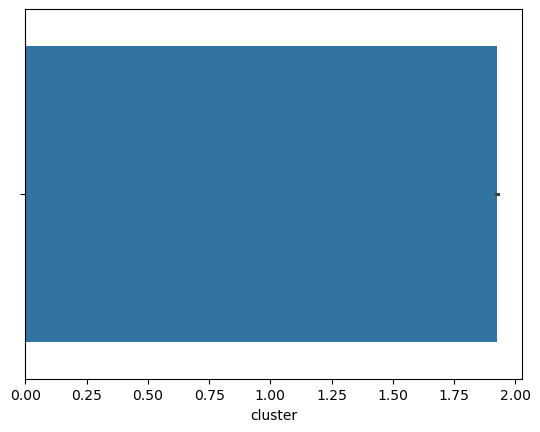

In [ ]:
sns.barplot(x=full_results["cluster"], y=)
plt.show()

from